In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline
from scipy import ndimage
#from matplotlib.animation import FuncAnimation
from warnings import warn
from PIL import Image
import time

In [28]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 23 14:44:46 2020

@author: William Kramer and Twan Gouwerok
"""
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.animation import FuncAnimation
from warnings import warn
from PIL import Image

plt.close("all")

#function for animating the .tif image
#def update(i,*args):
#    #this function updates the animation.
#        plt.imshow(getFrame(i*10, ext))
#        ax.set_title("frame: {} of 1000".format(i*10), fontsize=20)

#constants
fileloc = 'trap 20 mW_0.tif' #Hard-coded for now. Change to an 'open file' prompt when implementing the GUI.

#WARNING! DO NOT RUN THESE FUNCTIONS IN A LOOP WHILE show==1. This will produce four plots per iteration!
show = 1


l_pixel=46.8e-9


#step 1: check the file extension
ext = fileloc.split(".")[-1]
if ext == "tif":
    video = 1
    im = Image.open(fileloc, mode = 'r')
    num = im.n_frames
    h, b = im.size
if ext == "avi":
    #do some things with a video loading library
    "foo"
    
    
#prepare arrays for x, y estimates
Xest = np.zeros(num)
Yest = np.zeros(num)

#STEP2: check whether the data file exist, no need to run the calculation again
#     if not(exist([fileloc,filename,'.mat'])) %skipped for testing

#step 3: import the image into an array   
#prepare an array to save the image data
I = np.zeros((b-2, h), dtype = 'float')

def getFrame(i, ext):
    # This function returns the ith frame in the image as a 2D array of floats
    if ext == "tif":
        im.seek(i)
        I = np.array(im)[1:-1] #remove the top and bottom pixels
    if ext == "avi":
        #don't know how to process avi files yet.
        "foo"
    I[np.isnan(I)] = 0
    if np.any(I<0):
        warn('Image contains negative values')
    if show:
        plt.figure()
        plt.title("{}th frame".format(i))
        plt.imshow(I)
        plt.show()    
    return I
    
#step 4: calculate the noise in the image. 
def calculateNoise(I):
    # Delete background intensity
    In = I.flatten()           # Most Python functions don't work for a 2D array, so In has to be flattened.
    Im = np.sort(In)            # A sorted list of I, with background intensity. 
    plt.figure()
    plt.title('Sorted intensity values')
    plt.xlabel('x')   
    plt.ylabel('y')   
    plt.grid()
    plt.plot(Im)                # In this plot it can be seen that Im has been correctly sorted. 
    med = np.median(Im)         # The median of IM can be calculated from the flattened sorted array Im.       
    Imed = abs(I - med)
    

    # Calculate the noise intensity
    ilst = np.sort(Imed)                    # To create a sorted list of all present intensities.
    ilstflat = np.sort(ilst.flatten())      # ilst has to be flattened to find the max value with Python.
    ilst_t = ilst.transpose()       
    ilstflat_t = np.sort(ilst_t.flatten())  # With the normal flatten function the rows are put bewelow eacht other, but we wantto put the columns next to each other. Thus the transposed version of ilst is needed.
    b = len(Im)
    x = np.arange(1,b+1)
    Ihalf = (max(In)-med)/2
    # Ihalf=max(ilstflat)/2
    
    # Make sure that the flattened ilst is also sorted, otherwise the wrong index is found.
    xIhalf_value = list(filter(lambda i: i > Ihalf, ilstflat_t))[0]         # This function gives the first value where ilst > half. With this value it can be checked if the position calculated in the next line is correct.
    xIhalf = next(x for x, val in enumerate(ilstflat_t) 
                                  if val > Ihalf)                           # Here the position of the first index with a value bgger than Ihalf is found.
    
    range_up=int(np.floor(b/2))
    coeff1= np.polyfit(x[0:range_up], ilstflat_t[0:range_up],1)      
    coeff2 = np.polyfit(x[int(xIhalf):b], ilstflat_t[int(xIhalf):b], 1)     # Makes a linear fit to the highest half of all intnsities in 'ilist'. 
    if show:
        plt.figure()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Noise intensity')
        plt.grid()
        plt.plot(x,np.sort(ilstflat_t),'b-')    

    # The rightmost intersection is the chosen noise intensity which will be removed from all images.
    fit1 = np.polyval(coeff1,x)                                     # Returns an array of all values of the fitted line for evey x coordinate.
    fit2 = np.polyval(coeff2,x)                                         
    xcross=round((coeff1[1]-coeff2[1])/(coeff2[0]-coeff1[0]))
    ycross= np.polyval(coeff1,xcross)
    fit=np.concatenate([fit1[0:int(xcross-1)],fit2[int(xcross-1):]])
    if show:
        plt.plot(x,np.sort(ilstflat_t),'b-', x,fit,'r'), plt.ylim([0,max(ilstflat)])
    scale=max(x)/max(ilstflat)
    dist=np.sqrt((x-xcross)**2+(ycross-ilstflat_t*scale)**2)        # Calculates the difference between the true intensiies and the values of crossing fitted lines.
    xmindist = next(x for x, val in enumerate(dist) 
                                  if val == min(dist))              # Calculates the x value of the rightmost intersetion of the fitted line and the curve of all true intensities.
    threshold=ilstflat_t[(xmindist-1)]+np.std(ilst)                 # Calculates the intensity, which belongs to the above clculated x value. This equals the intensity of the noise which should be delete.
    if show:
        plt.plot(x,np.sort(ilstflat_t),'b-', x,fit,'k', xcross,ycross,'kx', xmindist, ilstflat_t[xmindist],'mo', [0,max(x)],[threhold,threshold],'r')     
    return threshold

#step5: subtract the noise from the image array
def removeNoise(I, Inoise):
    #This is done in two steps: first the background intensity is removed:
    med = np.median(I) #the median of all values in I is taken as the background intensity
    Ib = I - med
    #Then the calculated noise is removed.
    Ic = Ib - Inoise
    #Now make sure all values are positive.
    Ic[Ic<0] = 0
    if show:
        plt.figure()
        plt.subplot(311)
        plt.title("frame with noise and background")
        plt.imshow(I)
        plt.subplot(312)
        plt.title("frame with noise without background")
        plt.imshow(Ib)
        plt.subplot(313)
        plt.title("frame without noise")
        plt.imshow(Ic)
        plt.tight_layout()
        plt.show()
    return Ic

#animating the final matrix gives insight: It is a bit slow, however. Also, remember to set show=0 before animating.
#fig, ax = plt.subplots(figsize=(5, 8))
#anim = FuncAnimation(fig, update, frames=np.arange(0, int(num/10)), interval=1)

#if show:
    I = getFrame(53, "tif")
    Inoise = calculateNoise(I)
    Iclean = removeNoise(I, Inoise)
    plt.figure()
    plt.imshow(Iclean)
    plt.show()
    
    
#STEP6: Center Of Mass (COM)
def centerofmass(I):
    # calculate the total intensity
    M = np.sum(I)

    if M==0:  #if completely black image, then empty array is returned
        X = 0
        Y = 0
        print('black image')

    else:
        Y, X = ndimage.measurements.center_of_mass(I)

    if show:
        plt.figure()
        plt.imshow(I)
        plt.xlabel('x (pixels)')
        plt.ylabel('y (pixels)')
        plt.plot(X,Y,'rx',label="Center of Mass")
        plt.legend()
        print("Center of mass is X = %.2f, Y = %.2f"%(X,Y))

    return X,Y

In [ ]:
# Center of Mass

In [31]:
# QI Tracker 
# -*- coding: utf-8 -*-
"""
QI Tracker
Created on Thu Apr 23 14:44:46 2020

@authors: 
- Jasper van der Gronde, Fenna Timsi (class (OOP), init)
- 
"""

plt.close('all')

# Defining the tracker as a class would be more appropriate 
# seeing how the utility is a set of related variables and functions.

class QI_Tracker:
    # -------------------------------------------------------------------------------------------
    # QI Tracker Class Object.
    # For more information j.h.h.vandergronde@student.tudelft.nl
    # -------------------------------------------------------------------------------------------
    # CLASS ATTRIBUTES WHICH WILL BE STORED IN THE OBJECT.
    # IT CAN SIMPLY BE CALLED WITH self.attr INSIDE THE CLASS FUNCTIONS
    # OUTSIDE IT CAN ALSO BE CALLED, BUT NOW FROM THE OBJECT NAME (SEE EXAMPLE).
    # WHEN INITIALIZING THE OBJECT THEY CAN BE OVERWRITTEN BY SETTING THEM AS KEYWORD ARGUMENTS.
    # -------------------------------------------------------------------------------------------
    # numpy ndarray - contains the (first) image data
    image = 0
    # float - over-sampling of radial bins
    radialoversampling = 2.0
    # float - over-sampling of angular spokes
    angularoversampling = 0.7
    # float - minimum radius of polar grid
    minradius = 0.0
    # float - maxiumum radius of polar grid
    maxradius = 0.0
    # By default 2.5, but should be able to be changed in the init function as kwarg.
    max_radius_denom = 2.5
    # integer - no. of iterations
    iterations = 10
    # integer - no. of spokes per quadrant 
    spokesnoperquad = 0 
    # integer - no. of radial bins
    radbinsno = 0
    # numpy ndarray - linear space containg radii
    radbins = 0
    # numpy ndarray - linear space containing angles
    angles = 0
    # float - angilar step size
    angularstep = 0
    # numpy ndarray - grid containing angles
    argsgrid = 0
    # numpy ndarray - grid containing radii
    radiigrid = 0    
    # numpy ndarray - x coordinates from the sampled polar grid
    X0samplinggrid = 0
    # numpy ndarray - y coordinates from the sampled polar grid
    Y0samplinggrid = 0
    
    # This function initialize the QI_Tracker object which is called with:
    # var = QI_Tracker(image)
    def __init__(self, im, **kwargs):
        """
        Initializes the QI tracker class and returns the object.        
    
        Arguments:
        im -- Numpy 2D array of the (first) image

        Keyword arguments:
        radialoversampling
        angularoversampling
        minradius
        maxradius
        iterations
        ... and many other other attributes that are defined in the class.
        
        """
        assert 'np' in globals(), "numpy must be imported at the beginning of the file as np."
        assert 'plt' in globals(), "matplotlib.pyplot must be imported at the beginning of the file as plt."
        assert type(im) is list or type(im) is np.ndarray, "Image must be of type list or ndarray"
        assert len(im) > 0, "Image cannot be empty"
    
        # convert to numpy array if list is given.
        if type(im) is not np.ndarray: 
            im = np.array(im)
        
        self.image = im
            
        # Override the default class attributes from the keyword arguments
        # Condition: Only if they exist in the class.
        for arg, val in kwargs.items(): 
            if arg in dir(self): setattr(self, arg, val)
        
        # -------------------------------------------------------------------------------------------
        # Creating the polar grid.
        # -------------------------------------------------------------------------------------------
        # Define the max-radius of the polar grid.
        self.maxradius = np.min(self.image.shape)/self.max_radius_denom
        # The no. of radial bins is defined as (r_max - r_min) x over-sampling.
        # int(...) <--> Solves warning cannot safely be interpretated as integer.
        self.radbinsno = int((self.maxradius - self.minradius) *self.radialoversampling)
        # Generate a linear space of radii, with the sampling given by radbinsno.
        self.radbins = np.linspace(self.minradius, self.maxradius, self.radbinsno)
        # The no. of spokes per quadrant is defined as .5πr_max x over-sampling (in this case under-sampling)
        # int(...) <--> Solves warning cannot safely be interpretated as integer.
        self.spokesnoperquad = int(np.ceil( (1/2) *np.pi *self.maxradius *self.angularoversampling))
        # From the no. of spokes per quadrant compute the angles in an array with a linear space.
        # Start at -π/4 and end at the same location 7π/4.
        # The total number of points then becomes 4 times the no. of spokes per quadrant +1 (including zero)
        self.angles = np.linspace(-(1/4)*np.pi,(7/4)*np.pi, 4*self.spokesnoperquad +1) 
        # Define the angular step size, can also with self.angles[1] - self.angles[0]
        self.angularstep = np.pi/(2*self.spokesnoperquad)
        # Center the angles. 
        self.angles = self.angles[0:-1] + self.angularstep/2
        # Generate a 2D grid containing the angles (args) and radii.
        self.argsgrid, self.radiigrid = np.meshgrid(self.angles, self.radbins)
        # Create X,Y coords from the polar grid.
        self.X0samplinggrid = self.radiigrid*np.cos(self.argsgrid)
        self.Y0samplinggrid = self.radiigrid*np.sin(self.argsgrid)
        return None
    
    def show_grid(self):
        """
        Plots the polar grid
        """
        plt.clf()
        fig = plt.figure(figsize=(8,8), dpi=100)
        ext = [
            np.amin(self.angles), # x-min
            np.amax(self.angles), # x-max
            np.amin(self.radbins), # y-min
            np.amax(self.radbins) # y-max
        ]
        plt.subplot(121)
        plt.imshow(self.X0samplinggrid, extent=ext, aspect='auto', origin='center')
        plt.xlabel('angular bins')
        plt.ylabel('radial bins')
        plt.subplot(122)
        plt.imshow(self.Y0samplinggrid, extent=ext, aspect='auto', origin='center')
        plt.xlabel('angular bins')
        plt.ylabel('radial bins')
        plt.tight_layout()
        plt.show()
        
    # This function corresponds to the main function TrackXY_by_QI in the mathlab file    
    def track_xy(im, QI, sho, xm, ym):
        """
        Tracks the image
        
        Arguments:
        
        
        Keyword arguments:
        """
        return None

In [ ]:
qi_tracker = QI_Tracker(I)
qi_tracker.show_grid()

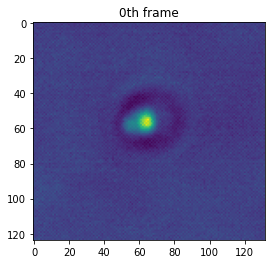

getFrame passed in 2.06e-01 seconds


LinAlgError: SVD did not converge in Linear Least Squares

In [34]:
#STEP8: QI tracker
def subpix_step(d):
    #this function performs a subpixel step by parabolic fitting
    hf = 3
    ld = len(d)
    xs = np.array(range(ld))
    x = np.max(d)
    lo = int(np.amax([x-hf,0])) #Cropping (must be atleast 0 to slice an array)
    hi = int(np.amin([x+hf, ld-1])) #Cropping (must be max ld-1 to slice an array
    ys = d[lo:hi]
    xs = xs[lo:hi]
    prms = np.polyfit(xs, ys, 2)
    return -prms[1]/(2*prms[0])

def SymCenter(prf):
    #this function find the symmetry center of an array.
    mp = np.nanmean(prf)
    sel = np.where(np.isnan(prf), mp, prf)   #If a NaN value is found, replace it with mp
    fw = prf - mp  #forward
    rv = np.fliplr(prf)- mp #reverse
    d = np.real(np.fft.ifft(np.fft.fft(fw)*np.conjugate(np.fft.fft(rv))))
    d = np.fft.fftshift(d).T  #Swap first and second half
    #[val, x] = np.max(d)
    return (subpix_step(d)+len(prf)/2)/2
    
# regular code [XQI,YQI]=TrackXY_by_QI(single(I),QI,0,xCOM,yCOM);
# regular function    function [xnw,ynw]=TrackXY_by_QI(im,QI,sho,xm,ym)
def track_xy(im, QI, sho, xm, ym):
        """
        Tracks the image
        
        Arguments:
        
        
        Keyword arguments:
        """
        #Initialise loop
        x_new = xm
        y_new = ym
        
        errx = np.zeros(qi_tracker.iterations)
        prequit = 0
        #iterative section; center position is iteratively improved
        for ii in range(qi_tracker.iterations):
            print('In loop %d' %ii)
            if not prequit:   #Note that this may stop the loop prematurely 
                x_old = x_new
                y_old = y_new
                X_samplinggrid = qi_tracker.X0samplinggrid+x_new  # now you see the advantage of QI-samplinggrid: no need to recalculate each iteration
                Y_samplinggrid = qi_tracker.Y0samplinggrid+y_new
                dim_y, dim_x = im.shape
                x_points = np.arange(-1/2*dim_x,1/2*dim_x)
                y_points = np.arange(-1/2*dim_y,1/2*dim_y)
                
                points_mesh = np.meshgrid(x_points, y_points)
                points = (points_mesh[0].flatten(), points_mesh[1].flatten())
                grid = (X_samplinggrid, Y_samplinggrid)
                allprofiles = griddata(points, im.flatten(),grid)
                print('QI.Y0samplingsgrid: ', qi_tracker.X0samplinggrid)

                
#                 allprofiles = RectBivariateSpline(X_samplinggrid, Y_samplinggrid, im)

                [aa, rara] = np.shape(X_samplinggrid)
                spokesnoperquad = round(aa/4)
                Qiprofs = np.zeros((4, rara))
                Qiprofs[0,:] = np.nanmean(allprofiles[0:spokesnoperquad]) #East
                Qiprofs[1,:] = np.nanmean(allprofiles[spokesnoperquad+1:2*spokesnoperquad]) #North
                Qiprofs[2,:] = np.nanmean(allprofiles[2*spokesnoperquad+1:3*spokesnoperquad]) #West
                Qiprofs[3,:] = np.nanmean(allprofiles[3*spokesnoperquad+1:4*spokesnoperquad]) #South
                
                QiHor = np.array([np.flip(Qiprofs[2,:]), Qiprofs[0,:]])
                QiVer = np.array([np.flip(Qiprofs[3,:]), Qiprofs[1,:]])
                #Get-image centered position, corrected for oversampling and off-center
                #sampling
                fudgefactor = np.pi/2
                SymCenter_QiHor = SymCenter(QiHor)
                SymCenter_QiVer = SymCenter(QiVer)
               
                x_new = -((len(QiHor)/2-SymCenter_QiHor)+0.5)/QI.radialoversampling/fudgefactor+x_new
                y_new = -((len(QiVer)/2-SymCenter_QiVer)+0.5)/QI.radialoversampling/fudgefactor+y_new
                
                
                if np.isnan(x_new) or np.isnan(y_new):
                    prequit = 1
                    print('black image')
                else:
                    errx[ii] = ((x_new-x_old)**2+(y_new-y_old)**2)
            else:
                prequit = 1
                x_new = x_old #fetch the old values
                y_new = y_old
            
            if show:
                plt.figure(6)
                plt.plot([x_old, x_new], [y_old, y_new], linestyle='-.')
        
        #print([x_old, x_new])
        if np.isnan(x_new) or np.isnan(y_new):
            x_new = x_old #fetch the old values
            y_new = y_old
        if show:
            plt.figure(5)
            aa, = np.shape(Xsamplinggrid)
            spokesnoperquad=round(aa/4)       
            plt.subplot(2,2,0)
            plt.plot(Xsamplinggrid[0:spokesnoperquad,:]+0.5,Ysamplinggrid[0:spokesnoperquad,:]+0.5,'r-')
            plt.plot(Xsamplinggrid[spokesnoperquad+1:2*spokesnoperquad,:]+0.5,Ysamplinggrid[spokesnoperquad+1:2*spokesnoperquad,:]+0.5,'k-')
            plt.plot(Xsamplinggrid[2*spokesnoperquad+1:3*spokesnoperquad,:]+0.5,Ysamplinggrid[2*spokesnoperquad+1:3*spokesnoperquad,:]+0.5,'r-')
            plt.plot(Xsamplinggrid[3*spokesnoperquad+1:4*spokesnoperquad,:]+0.5,Ysamplinggrid[3*spokesnoperquad+1:4*spokesnoperquad,:]+0.5,'k-')
            plt.plot(xm+0.5,ym+0.5, 'wx', 15)
            plt.plot(x_old+0.5,y_old+0.5, 'w+', 15)
            plt.plot(x_new+0.5,y_new+0.5, 'wsq', 15)     
            plt.title('Image&sampling grid')      

            plt.subplot(2,2,1)
            plt.plot(Qiprofs[0,:].T, label='East')
            plt.plot(Qiprofs[1,:].T, label='North')
            plt.plot(Qiprofs[2,:].T, label='West')
            plt.plot(Qiprofs[3,:].T, label='South')
            plt.title('profiles')
            plt.xlabel('sampling steps')
            plt.ylabel('value, a.u.')
            plt.legend() 
              
            plt.subplot(2,2,2)
            plt.plot(QiHor, 'r-', label='Hor')
            plt.plot(QiVer, label='Ver')
            plt.title('concatenated profiles')
            plt.legend()
            plt.xlabel('sampling steps')
            plt.ylabel('value, a.u.')        
            
            plt.subplot(2,2,3);
            plt.plot(errx[0],'k-o')
            plt.title('iteration progress')
            plt.xlabel('iteration step no.')
            plt.ylabel('translation per step, pixel units')
            plt.show()
        
        XQI = x_new
        YQI = y_new
        
        Xest[0] = XQI
        Yest[0] = YQI
    
start = time.time()
I = getFrame(0,'tif')
stop = time.time()
print('getFrame passed in %.2e seconds' %(stop-start))

start = time.time()
threshold = calculateNoise(I)
stop = time.time()
print('calulateNoise passed in %.2e seconds' %(stop-start))
    
start = time.time()
I_filtered = removeNoise(I,threshold)
stop = time.time()
print('removeNoise passed in %.2e seconds' %(stop-start))

start = time.time()
xm, ym = centerofmass(I_filtered)
stop = time.time()
print('centerofmass passed in %.2e seconds' %(stop-start))
print('XCOM, YCOM =', xm, ym)
track_xy(I, qi_tracker, show, xm, ym)

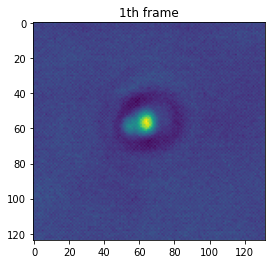

NameError: name 'x_new' is not defined

In [35]:
### Step 9: make it into a loop over all images
from tqdm.notebook import tqdm
pbar = tqdm(total=num)

for i in range(1,num):
    pbar.update(1)
    
    I = getFrame(i,ext)
    [X_est[i],Y_est[i]] = track_xy(I, qi_tracker, show, x_new, y_new)

np.savetext('{}/estimates.mat'.format(fileloc), np.array([X_est,Y_est]), delimiter =',' )
pbar.close()
plt.show()
    
    